<a href="https://colab.research.google.com/github/Lucho90/Lucho90-Learning_projects/blob/main/Sistema_de_recomendaci%C3%B3n_Steam_basado_en_horas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistemas de recomendación Steam basado en horas jugadas

## Dataset: 
**(https://github.com/kang205/SASRec).**





#Introducción



En este proyecto se pretende hacer un sistema de recomendación basandose en dos datasets de STEAM uno que contiene las reviws de los usuarios y otro que contiene la información de cada juego. STEAM es una biblioteca de videojuegos en donde el usuario puede comprar y almacenar videojuegos, es una plataforma que lleva ya más de 10 años en la web y en la que se encuentran usuarios de todo el mundo.

El sistema de recomendación que se busca hacer es uno colaborativo, es decir, se recomienda contenido para usuarios similares. Por ejemplo, si tanto el usuario A como el B juegan: tetris, súper mario y zelda, pero el usuario A adicionalmente ama jugar Pokemón, el sistema recomendará este juego al usuario B.

Para el tratamiento de los datos iniciemos importando estas librerias: 

In [1]:
import gzip
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def parse(path):   
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

##**Reviews**

Iniciemos con el dataset de las reviws (uno bastante pesado), para ello guardaremos 1 de cada 5 reviws. Aunque es pesado este proceso, pienso guardar tantas reviews porque se pronostica que al centrarse en un periodo de tiempo especifico y al deshacerse de outliers, además, pueda quedar un dataset mucho más corto. 

In [ ]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 5
for l in parse('steam_reviews.json.gz'):
    if contador % n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [ ]:
data_reviews = pd.DataFrame(data_reviews)

In [ ]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,user_id,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Teef 🐏,0.9,923.0,725280,1,2017-12-03,hey thanks for stealing my spritework,False,1,1.0,NaN,NaN
2,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
3,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
4,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


In [ ]:
data_reviews.isna().sum()

username              0
hours              5325
products           3041
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
found_funny     1318177
user_id          923376
compensation    1529508
dtype: int64

Datos que parecen de interes: porduct_id, username y hours. La columna de text podría ser de interes para analizar la opinion del usuario frente al juego, pero, dado que está compuesta por diferentes idiomas, será mejor pasarla por alto. Por otro lado, las columnas user_id, compensation y found_funny tienen suficientes valores faltantes para que consideremos no usarlas. Pero no hay necesidad de preocuparse, con las que nos generan interes nos basta.

In [ ]:
data_reviews.shape

(1558614, 12)

In [ ]:
data_reviews.username.value_counts()

123              400
Alex             389
Chris            293
Nick             292
Tom              270
                ... 
We won 1812        1
Foufou             1
tersse             1
j0j0™              1
Salted-Peanut      1
Name: username, Length: 919179, dtype: int64

Empecemos por lo fundamental: Solucionar la lidia de subir el dataset de las reviws cada vez que vamos a trabajar. Para ello, lo que haré es crear un archivo csv con los datos que filtre de las reviews. Este dataset nuevo estará limitado a los datos del año 2017.

In [ ]:
data_año = data_reviews[(data_reviews['date'] > '2017-01-01') & (data_reviews['date'] < '2017-12-31')]
data_año.shape

(480258, 12)

In [ ]:
reviws = pd.DataFrame(data=data_año,columns=['username','hours','product_id'])

In [ ]:
reviws.to_csv(r'reviws.csv', index = False)

##**Games**

Revisemos ahora el dataset de los juegos:

In [2]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [3]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [4]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


Viendo el ejemplo de dato por encima, se puede decir que los datos de interes son: id, sentiment y metascore; pues se cree que estos son los datos que nos hablaran sobre la calificación general del juego. 
Otros datos que parecen interesantes son el de precio, tags, generes. Se debe tener en cuenta que el precio puede variar en el tiempo (dependiendo de promociones, por ejemplo).

Pero por ahora, los datos de mayor interes son los de id y los de app_name, este dataset lo usaremos especificamente para darle el nombre del juego a las recomendaciones que se hagan al usuario.


In [5]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [8]:
data_games['id'].nunique() #Cantidad de juegos

32132

Hay una gran cantidad de datos faltantes entre ellas el metascore y discount_price, la primera puede estar siendo descartada de nuestro modelo debido a tal falta de valores, mientras que la segunda se entiende dado que no todos los juegos cuentan con precio de descuento.
Por otro lado, las demás variables que parecen de interes parecen tener una cantidad de valores ausentes con la que no se verá muy comprometido el modelo.

In [9]:
data_games['developer'].value_counts()

Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
                              ... 
KADOKAWA,Despain                 1
PowPow                           1
Bloom Digital Media              1
Ghulam Jewel                     1
Khud0                            1
Name: developer, Length: 10992, dtype: int64

En este dataset se observa que aunque hay una gran cantidad de empresas, pocas empresas pasan de publicar más de 100 juegos. Este dato no es un outlier, pues es sabido que steam da la oportunidad a empresas pequeñas de publicar sus juegos, estas por lo general no cuentan con un gran repositorio.

In [10]:
data_games.price.value_counts()

4.99             4278
9.99             3902
2.99             3429
0.99             2607
1.99             2541
                 ... 
Free Movie          1
10.49               1
189.96              1
Play the Demo       1
0.5                 1
Name: price, Length: 162, dtype: int64

Al contar los valores de precio aparecen varios valores que no son numericos, por lo que para analizar los precios se deben remplazar estos valores por numericos, así como cambiar el tipo de dato de string a int.

In [11]:
data_games["price"].replace({"Free To Play": 0 , "Play the Demo": 0 ,"Free to Play":0,
                             "Free":0,"Free Demo":0,"Play for Free!":0,
                             "Install Now":0,"Play WARMACHINE: Tactics Demo":0,
                             "Free Mod":0,"Install Theme":0,
                             "Third-party":0,"Play Now":0,"Free HITMAN":0,
                             "Free HITMAN™ Holiday Pack":0,
                             "Starting at $499.00":499,
                             "Starting at $449.00":499,"Free to Try":0,
                             "Free Movie":0,"Free to Use":0}, inplace=True)

Luego de remplazar los valores no numericos por números, cambiamos el tipo de dato de toda la columna a int.

In [12]:
data_games['price'] = pd.to_numeric(data_games['price'])

Ahora creamos 10 bins para ver la distribución de los precios en el dataset.

In [13]:
data_games['price_inter'] = pd.cut(data_games.price,bins=10,include_lowest=False)

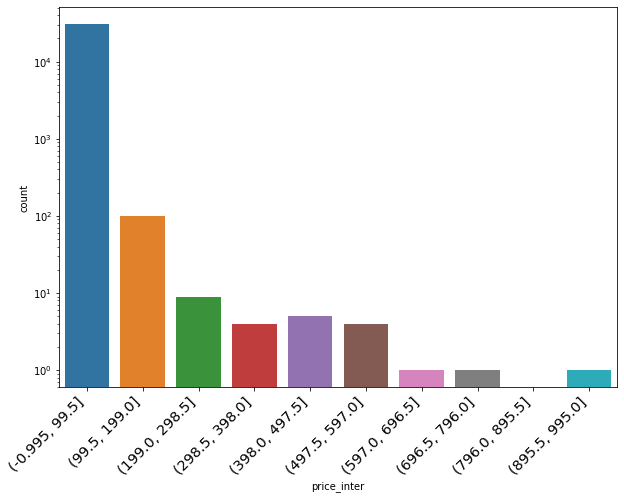

In [14]:
plt.figure(figsize=(10,7))
chart=sns.countplot(data=data_games,x=data_games.price_inter)
plt.yscale('log')
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
sns.set_style()

Se puede ver que existe un valor máximo de 995 dolares, este valor puede considerarse un outlier dado que la mayor parte de valores se concentran entre los 0 (gratuidad) y los 100 dolares. A continuación observamos un resumen los datos de la anterior gráfica resumidos.

In [15]:
data_games.price_inter.value_counts()

(-0.995, 99.5]    30634
(99.5, 199.0]        99
(199.0, 298.5]        9
(398.0, 497.5]        5
(497.5, 597.0]        4
(298.5, 398.0]        4
(895.5, 995.0]        1
(696.5, 796.0]        1
(597.0, 696.5]        1
(796.0, 895.5]        0
Name: price_inter, dtype: int64

Finalmente convertimos la columna de id a valores númericos para poder trabajar facilmente con ella en el futuro.

In [16]:
data_games['id'] = pd.to_numeric(data_games['id'])

# Preparando el Dataset

Traemos nuestros datos de usuarios del año 2017 para empezar a procesar los datos.

In [44]:
reviws = pd.read_csv('reviws.csv')
reviws.head()

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Teef 🐏,0.9,725280
2,Ariman1,13.2,328100
3,freakfantom,0.1,725280
4,Kaelandros,1.5,328100


Revisemos los datos duplicados del dataset y valores faltantes primero.

In [45]:
reviws.duplicated(["username","hours", "product_id"]).sum()

10768

In [46]:
reviws = reviws.drop_duplicates()

In [47]:
reviws.isna().sum()

username        4
hours         601
product_id      0
dtype: int64

In [48]:
reviws = reviws.dropna()

El siguiente paso será crear una columna nueva en donde se dirá el total de horas jugadas por cada usuario. Para ello primero convertimos los valores de horas de string a numericos:

In [49]:
reviws['hours'] = pd.to_numeric(reviws['hours'])

Con esta siguiente linea de codigo se agrupan y suman las horas por usuario y se crea un nuevo dataset.

In [50]:
gr = reviws.groupby(['username'])
total = pd.DataFrame(gr['hours'].sum())
total.head()

,hours
username,
!,6.5
! *,7.9
! DeadlyDeal !,20.1
! Dr Feelgood,5.4
! EREN,10.0


Finalmente, se crea la columna deseada y se llena con el total de horas por usuario.

In [51]:
reviws['total']=total
reviws['total'].fillna(gr.hours.transform("sum"),inplace=True)
reviws.head()

,username,hours,product_id,total
0,Chaos Syren,0.1,725280,0.1
1,Teef 🐏,0.9,725280,20.6
2,Ariman1,13.2,328100,19.1
3,freakfantom,0.1,725280,0.1
4,Kaelandros,1.5,328100,1.5


Seguidamente, se crea una nueva columna llamada 'play_game' en donde se informa el porcentaje de tiempo que cada usuario dedico a cada juego.

In [52]:
reviws['play_game']= reviws['hours']/reviws['total']
reviws.head()

,username,hours,product_id,total,play_game
0,Chaos Syren,0.1,725280,0.1,1.000000
1,Teef 🐏,0.9,725280,20.6,0.043689
2,Ariman1,13.2,328100,19.1,0.691099
3,freakfantom,0.1,725280,0.1,1.000000
4,Kaelandros,1.5,328100,1.5,1.000000


In [53]:
reviws.sort_values('total',ascending=False) 

,username,hours,product_id,total,play_game
348520,123,2372.3,346110,223631.9,0.010608
347445,123,752.1,346110,223631.9,0.003363
345828,123,3925.7,346110,223631.9,0.017554
99141,123,79.5,289070,223631.9,0.000355
12989,123,69.3,271590,223631.9,0.000310
...,...,...,...,...,...
121011,Phyroks,0.1,392080,0.1,1.000000
341511,Profeser Boxer >:),0.1,230410,0.1,1.000000
65333,SkyAdmiralDante,0.1,452510,0.1,1.000000
121019,Onno,0.1,250600,0.1,1.000000


Se puede observar que en el total de horas jugadas vemos dos outliers: exceso de horas jugadas (más de las horas que tiene un año) y un minimo de horas de 10 minutos. Con estos datos lidiaremos más adelante...

In [54]:
print('Tamaño de reviws.csv')
print(reviws.shape)
print('Valores faltantes:')
print(reviws.isna().sum())

Tamaño de reviws.csv
(468885, 5)
Valores faltantes:
username      0
hours         0
product_id    0
total         0
play_game     0
dtype: int64


Revisemos como se ve la información de 1 solo usuario.

In [55]:
dr=reviws[(reviws['username']=='The_Cpt_FROGGY')] #&(reviws['play_game']>=0.05)
dr = dr.sort_values('play_game',ascending=False)
dr

,username,hours,product_id,total,play_game
169410,The_Cpt_FROGGY,18.7,489520,152.1,0.122945
204156,The_Cpt_FROGGY,10.6,380920,152.1,0.069691
33298,The_Cpt_FROGGY,10.1,572520,152.1,0.066404
418066,The_Cpt_FROGGY,9.5,570980,152.1,0.062459
382580,The_Cpt_FROGGY,8.3,616240,152.1,0.054569
27042,The_Cpt_FROGGY,8.3,493540,152.1,0.054569
205276,The_Cpt_FROGGY,8.1,348160,152.1,0.053254
5,The_Cpt_FROGGY,7.8,631920,152.1,0.051282
1186,The_Cpt_FROGGY,7.3,482440,152.1,0.047995
363519,The_Cpt_FROGGY,7.1,658790,152.1,0.046680


La cantidad de productos que tiene el usuario es:

In [56]:
print(dr.shape)
print(len(dr['product_id'].unique()))

(20, 5)
20


Y, ahora bien, la cantidad de usuarios que tenemos y productos es:

In [57]:
print(len(reviws['username'].unique())) #Valores únicos de usuario
print(len(reviws['product_id'].unique())) # Valores único de productos

345071
11955


Agregar columna con el nombre del juego. Esto es traer desde el dataset de steam_games el app_name correspondiente a cada id. Para ello primero traemos la data en games solo app_name e id.

In [58]:
games = pd.DataFrame(data_games[['app_name','id']])
games = games.rename(columns={'app_name':'name','id':'product_id'})
games.head()

,name,product_id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,弹炸人2222,767400.0
4,Log Challenge,773570.0


Sacamos los valores faltantes.

In [ ]:
games.isna().sum()

name          2
product_id    2
dtype: int64

In [ ]:
games = games.dropna()

Y agregamos la información a nuestro dataset 'reviws'.

In [ ]:
reviws= pd.merge(reviws,games)
reviws.head()

,username,hours,product_id,total,play_game,name
0,Chaos Syren,0.1,725280,0.1,1.000000,Psi Project
1,Teef 🐏,0.9,725280,20.6,0.043689,Psi Project
2,freakfantom,0.1,725280,0.1,1.000000,Psi Project
3,Ariman1,13.2,328100,19.1,0.691099,Gunspell - Steam Edition
4,Kaelandros,1.5,328100,1.5,1.000000,Gunspell - Steam Edition


##Formas de abordar el problema

**Idea 1**
Se puede traducir las horas jugadas en un rating de 5 calificaciones haciendo uso de la media y las disviaciones estandar.

**Idea 2**
Acercar a los usuarios acorde a productos más jugados, recomendando los juegos que sean jugados por encima de la media en una calificación de 1 a 2.

* 1 o negativo, quiere decir que las horas invertidas en ese juego por el usuario han sido por debajo del promedio de sus demás juegos.
* 2 o positivo, quiere decir que las horas invertidas en ese juego por el usuario están por encima o en el promedio de las horas jugadas.

Ambas ideas parecen muy racionales así que usaremos primero la número 2 (qué es más simple) para nuestro modelo de benchmark y la 1 para optimizar el modelo.

#Modelo benchmark

Primero se debe agregar la columna que llamare rankings.

In [59]:
gr = reviws.groupby(['username'])

In [60]:
reviws.loc[:,'mean_hour']= np.nan
reviws.loc[:,'mean_hour'].fillna(gr.play_game.transform("mean"),inplace=True)
reviws.loc[:,'std_hour'] = np.nan
reviws.loc[:,'std_hour'].fillna(gr.play_game.transform('std'),inplace=True)
reviws.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,NaN
1,Teef 🐏,0.9,725280,20.6,0.043689,0.333333,0.531378
2,Ariman1,13.2,328100,19.1,0.691099,0.250000,0.300531
3,freakfantom,0.1,725280,0.1,1.000000,1.000000,NaN
4,Kaelandros,1.5,328100,1.5,1.000000,1.000000,NaN


Es de notarse que para algunos usuarios la desviación estandar del tiempo jugado aparece como un valor NAN, esto se debe a que no existe tal desviación y estamos hablando de personas que solo jugaron un juego, por lo que la desviación estandar del tiempo jugado será de 0. Para estos casos se pueden tomar dos enfoques: Se reemplazan los valores NAN por 0 ó se eliminan los valores NAN.

In [61]:
print('Tamaño de la data: ',len(reviws))
print('Datos NAN de std_hour:',reviws['std_hour'].isna().sum())
print('Data sin NAN: ',len(reviws)-reviws['std_hour'].isna().sum())

Tamaño de la data:  468885
Datos NAN de std_hour: 287101
Data sin NAN:  181784


Los valores NAN en la desviación estandar corresponden a una desviación de 0, lo que se relaciona a que el usuario solo ha jugado 1 videojuego durante todo el periodo de tiempo. Entonces, cambiamos el valor NAN por 0.



In [62]:
reviws = reviws.fillna(0)
reviws.shape

(468885, 7)

Aquí se puede apreciar la información hasta ahora recolectada por usuario.

In [63]:
reviws[reviws['username']=='dll3z']

,username,hours,product_id,total,play_game,mean_hour,std_hour
25,dll3z,0.4,328100,0.4,1.0,1.0,0.0


Procedemos a asignar puntajes de 1,2 y 3. siendo respectivamente que juega 1.5 desviaciones estandar por encima de la media, juega por encima de la media y que juega por debajo de la media el producto.

In [65]:
puntaje_3 =  reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour'] + 1.5*reviws.loc[:,'std_hour']
puntaje_2 =   reviws.loc[:,'play_game'] >= reviws.loc[:,'mean_hour']  
puntaje_1 =   reviws.loc[:,'play_game'] < reviws.loc[:,'mean_hour']        
conditions  = [ puntaje_3,puntaje_2,puntaje_1 ]
choices     = [ 3,2,1 ]

reviws.loc[:,'ranking'] = np.select(conditions, choices, default=np.nan)
reviws.head(10)

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,3.0
1,Teef 🐏,0.9,725280,20.6,0.043689,0.333333,0.531378,1.0
2,Ariman1,13.2,328100,19.1,0.691099,0.250000,0.300531,2.0
3,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,3.0
4,Kaelandros,1.5,328100,1.5,1.000000,1.000000,0.000000,3.0
5,The_Cpt_FROGGY,7.8,631920,152.1,0.051282,0.050000,0.020863,2.0
6,Myantro,8.8,431320,61.5,0.143089,0.125000,0.080171,2.0
7,S0YxSauCe,0.3,671270,39.1,0.007673,0.062500,0.051312,1.0
8,Vonder,2.7,35600,30.0,0.090000,0.333333,0.219570,1.0
9,GozerGozerian,1.1,448800,112.8,0.009752,0.166667,0.167442,1.0


Observemos como se distribuyen las calificaciones de los juegos.

In [66]:
reviws['ranking'].value_counts()

3.0    293878
1.0    108892
2.0     66115
Name: ranking, dtype: int64

Ahora bien, antes de aplicar nuestro modelo, es muy recomendable que lidiemos con los outliers de horas jugadas, pues hay usuarios que para 2017 registran más horas jugadas que las horas que tiene el año. 

In [70]:
maximo= 8760 # Las horas que contiene un año
# Con el outlier minimo ya lidiamos al eliminar quienes tenian 0 horas jugadas.
reviws= reviws.drop(reviws[reviws['total']>maximo].index)
reviws.shape

(467837, 8)

In [71]:
! pip install numpy
! pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.2MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670934 sha256=66766d3fd119d44d85a40fa08497edbded55d63c3f238fb943b290d3efaa2796
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [72]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

In [73]:
reader = Reader()

In [74]:
N_filas = len(reviws) # Limitamos el dataset a N_filas

data = Dataset.load_from_df(reviws[['username', 'product_id', 'ranking']][:N_filas], reader)

In [75]:
trainset, testset = train_test_split(data, test_size=.25)

In [76]:
from surprise import SVD
bench = SVD()

In [77]:
bench.fit(trainset)

In [78]:
predictions_bench = bench.test(testset)

In [79]:
predictions_bench[1]

Prediction(uid='DJMonking', iid=304390, r_ui=3.0, est=2.848348576629117, details={'was_impossible': False})

Para predecir usuario escribimos el usuario y el id del juego en este caso, el usuario 'The_Cpt_FROGGY' con el juego Batman Arkham Asylum. Para este caso vemos que el modelo estima que el juego si será jugado por este usuario.

In [80]:
bench.predict('The_Cpt_FROGGY',35140)

Prediction(uid='The_Cpt_FROGGY', iid=35140, r_ui=None, est=1.5795533555593377, details={'was_impossible': False})

Los juegos que el anterior usuario prefirió o jugó por encima de la media fueron:

In [81]:
usuario = 'The_Cpt_FROGGY'
ranking = 3   # Juegos jugados por encima del tiempo promedio
df_user = reviws[(reviws['username'] == usuario) & (reviws['ranking'] == ranking)]
df_user = df_user.reset_index(drop=True)
#df_user['GAME_Name'] = data_games['app_name'].loc[reviws.product_id].values
df_user

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
0,The_Cpt_FROGGY,18.7,489520,152.1,0.122945,0.05,0.020863,3.0


In [82]:
recomendaciones_usuario = games.iloc[:].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32135, 2)


,name,product_id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,弹炸人2222,767400.0
4,Log Challenge,773570.0


In [83]:
usuario_vistas = reviws[reviws['username'] == usuario]
#usuario_vistas = usuario_vistas[['name','product_id']]
print(usuario_vistas.shape)
usuario_vistas.head()

(20, 8)


,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
5,The_Cpt_FROGGY,7.8,631920,152.1,0.051282,0.05,0.020863,2.0
1186,The_Cpt_FROGGY,7.3,482440,152.1,0.047995,0.05,0.020863,1.0
21768,The_Cpt_FROGGY,4.7,736860,152.1,0.030901,0.05,0.020863,1.0
27042,The_Cpt_FROGGY,8.3,493540,152.1,0.054569,0.05,0.020863,2.0
33298,The_Cpt_FROGGY,10.1,572520,152.1,0.066404,0.05,0.020863,2.0


In [84]:
#recomendaciones_usuario = pd.concat([usu, df1, df1]).drop_duplicates(keep=False)
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,index,name,product_id
0,0,Lost Summoner Kitty,761140.0
1,1,Ironbound,643980.0
2,2,Real Pool 3D - Poolians,670290.0
3,3,弹炸人2222,767400.0
4,4,Log Challenge,773570.0


In [85]:
len(recomendaciones_usuario) 

32135

Se realiza la recomendación.

In [157]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: bench.predict(usuario, x).est)

In [158]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,level_0,index,name,product_id,Estimate_Score
441,7260,7260,Paladins®,444090.0,2.400765
182,23937,23937,Lost Lands: Mahjong,435030.0,2.372354
8,5199,5199,Knight Online,389430.0,2.355085
34,8933,8933,Dungeon Painter Studio,592260.0,2.345154
41,15618,15618,Divinity: Original Sin 2,435150.0,2.305529
757,24356,24356,Naval Action,311310.0,2.293678
13,17150,17150,Kemono Friends,653320.0,2.292217
129,3625,3625,TERA,323370.0,2.285783
3835,29692,29692,Rust,252490.0,2.281984
35,7318,7318,hackmud,469920.0,2.278154


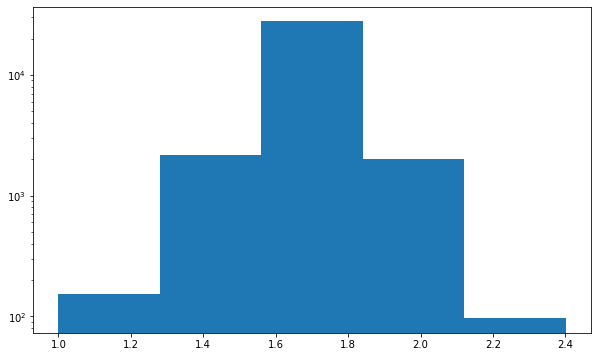

In [159]:
plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=5)
plt.yscale('log')
plt.show()

In [160]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=5,sort=False)

(0.998, 1.28]       152
(1.28, 1.56]       2151
(1.56, 1.84]      27717
(1.84, 2.121]      2018
(2.121, 2.401]       97
Name: Estimate_Score, dtype: int64

El modelo de benchmark nos arroja en los resultados la mayoría de los datos como juegos por debajo de 2, es decir, juegos que no se recomendarían al usuario. Por otro lado no llega a recomendar productos con una predicción de 3. La recomendación, en este caso, sería de los valores superiores a 2, que son los juegos que el usuario jugaría constantemente.

Ahora bien, veamos como se comporta el modelo con un usuario que solo posee un producto:

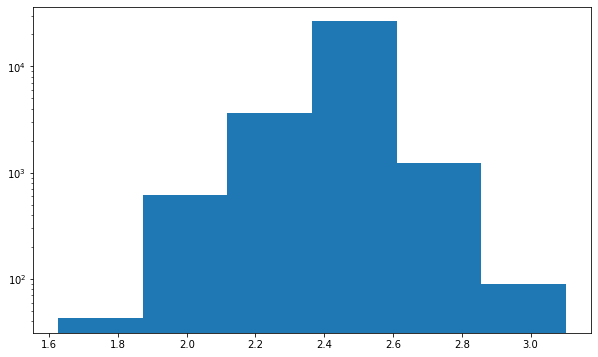

In [162]:
usuario1_5 = 'Kaelandros'
ranking = 3   # Juegos jugados por encima del tiempo promedio
df_user = reviws[(reviws['username'] == usuario1_5) & (reviws['ranking'] >= ranking)]
df_user = df_user2.reset_index(drop=True)
usuario_vistas = reviws[reviws['username'] == usuario1_5]
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: bench.predict(usuario1_5, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)

plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=6)
plt.yscale('log')
plt.show()

In [163]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=6,sort=False)

(1.624, 1.873]       43
(1.873, 2.119]      620
(2.119, 2.365]     3684
(2.365, 2.61]     26469
(2.61, 2.856]      1230
(2.856, 3.102]       89
Name: Estimate_Score, dtype: int64

El modelo concentra los datos por encima del valor 2 (juegos jugados en promedio) y llega a predecir valores con nota 3. Para este usuario partícular se pueden recomendar los valores superiores a 3. 
Claramente los datos sugieren, por otro lado, que al usuario tener solo un producto, tiene mayor probabilidad de "enganche" con más productos, pues le es imposible saber al modelo que no le gusta mas que por similaridades con otros usuarios. 

##Error del modelo benchmark

In [90]:
from surprise import accuracy

In [91]:
accuracy.rmse(predictions_bench, verbose=True)

RMSE: 0.7492


0.7491665287451655

Ahora bien, se deben contrastar los anteriores resultados con la medida del error RMSE de 0.74 que quiere decir que nuestros puntajes estan casi media unidad por arriba o por debajo de su calificación ideal. Esto hace los resultados poco alentadores, al menos por ahora, pues al tener una escala tan pequeña de calificación (de uno a tres) este error es mucho más significativo que si estubieramos calificando de 1 a 100. 

#Modelo SVD optimizado

Para mejorar el modelo iniciemos tratando nuevamente nuestra data.

In [116]:
reviws2 = pd.read_csv('reviws.csv')
reviws2['hours'] = pd.to_numeric(reviws2['hours'])
reviws2 = reviws2.drop_duplicates()
reviws2 = reviws2.dropna()
gr2 = reviws2.groupby(['username'])
total2 = pd.DataFrame(gr2['hours'].sum())
reviws2['total']=total2
reviws2['total'].fillna(gr2.hours.transform("sum"),inplace=True)
reviws2['play_game']= reviws2['hours']/reviws2['total']

reviws2.head()

,username,hours,product_id,total,play_game
0,Chaos Syren,0.1,725280,0.1,1.000000
1,Teef 🐏,0.9,725280,20.6,0.043689
2,Ariman1,13.2,328100,19.1,0.691099
3,freakfantom,0.1,725280,0.1,1.000000
4,Kaelandros,1.5,328100,1.5,1.000000


Eliminamos outliers.

In [117]:
maximo= 8760 # Las horas que contiene un año
# Con el outlier minimo ya lidiamos al eliminar quienes tenian 0 horas jugadas.
reviws= reviws.drop(reviws[reviws['total']>maximo].index)
#reviws= reviws.drop(reviws[reviws['total']<minimo].index)
reviws.shape

(467837, 8)

Sacamos la división estandar para luego generar nuestros rankings

In [118]:
reviws2.loc[:,'mean_hour']= np.nan
reviws2.loc[:,'mean_hour'].fillna(gr2.play_game.transform("mean"),inplace=True)
reviws2.loc[:,'std_hour'] = np.nan
reviws2.loc[:,'std_hour'].fillna(gr2.play_game.transform('std'),inplace=True)
reviws2.head()

,username,hours,product_id,total,play_game,mean_hour,std_hour
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,NaN
1,Teef 🐏,0.9,725280,20.6,0.043689,0.333333,0.531378
2,Ariman1,13.2,328100,19.1,0.691099,0.250000,0.300531
3,freakfantom,0.1,725280,0.1,1.000000,1.000000,NaN
4,Kaelandros,1.5,328100,1.5,1.000000,1.000000,NaN


Nuevamente, cambiamos los valores NAN por 0.

In [119]:
reviws2 = reviws2.fillna(0)

Ahora generamos nuestros puntajes de 1 a 5, siendo 1 un juego poco jugado y 5 un juego al que se le dedica mucho tiempo.

In [120]:
puntaje_5 =  reviws2.loc[:,'play_game'] >= reviws2.loc[:,'mean_hour'] + 2*reviws2.loc[:,'std_hour']
puntaje_4 =  reviws2.loc[:,'play_game'] >= reviws2.loc[:,'mean_hour'] + 1.5*reviws2.loc[:,'std_hour']
puntaje_3 =   reviws2.loc[:,'play_game'] >= reviws2.loc[:,'mean_hour'] + reviws2.loc[:,'std_hour']
puntaje_2 = reviws2.loc[:,'play_game'] >= reviws2.loc[:,'mean_hour'] 
puntaje_1 =   reviws2.loc[:,'play_game'] < reviws2.loc[:,'mean_hour']        
conditions  = [ puntaje_5,puntaje_4,puntaje_3,puntaje_2,puntaje_1 ]
choices     = [ 5,4,3,2,1 ]

reviws2.loc[:,'ranking'] = np.select(conditions, choices, default=np.nan)
reviws2.head(10)

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
0,Chaos Syren,0.1,725280,0.1,1.000000,1.000000,0.000000,5.0
1,Teef 🐏,0.9,725280,20.6,0.043689,0.333333,0.531378,1.0
2,Ariman1,13.2,328100,19.1,0.691099,0.250000,0.300531,3.0
3,freakfantom,0.1,725280,0.1,1.000000,1.000000,0.000000,5.0
4,Kaelandros,1.5,328100,1.5,1.000000,1.000000,0.000000,5.0
5,The_Cpt_FROGGY,7.8,631920,152.1,0.051282,0.050000,0.020863,2.0
6,Myantro,8.8,431320,61.5,0.143089,0.125000,0.080171,2.0
7,S0YxSauCe,0.3,671270,39.1,0.007673,0.062500,0.051312,1.0
8,Vonder,2.7,35600,30.0,0.090000,0.333333,0.219570,1.0
9,GozerGozerian,1.1,448800,112.8,0.009752,0.166667,0.167442,1.0


Miremos, para este nuevo puntaje la distribución de los puntajes.

In [121]:
reviws2['ranking'].value_counts()

5.0    290614
1.0    108892
2.0     51591
3.0     14524
4.0      3264
Name: ranking, dtype: int64

In [122]:
N_filas = len(reviws) # Limitamos el dataset a N_filas

data2 = Dataset.load_from_df(reviws2[['username', 'product_id', 'ranking']][:N_filas], reader)

In [100]:
from surprise.model_selection import GridSearchCV
# Hora de tomarse un cafe ... (-_-)zzzz
param_grid = {'n_factors': [5,10],'n_epochs': [5,30,60], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.6862407947248365
{'n_factors': 5, 'n_epochs': 60, 'lr_all': 0.005, 'reg_all': 0.02}


In [123]:
trainset, testset = train_test_split(data2, test_size=.25)

In [124]:
model = SVD(n_factors=5, n_epochs=60,lr_all=0.005, reg_all=0.02)

In [125]:
model.fit(trainset)

In [126]:
predictions = model.test(testset)

In [127]:
model.predict('The_Cpt_FROGGY',35140)

Prediction(uid='The_Cpt_FROGGY', iid=35140, r_ui=None, est=1.9325025752221934, details={'was_impossible': False})

In [140]:
usuario2 = 'The_Cpt_FROGGY'
ranking2 = 3   # Juegos jugados por encima del tiempo promedio
df_user2 = reviws2[(reviws2['username'] == usuario2) & (reviws2['ranking'] >= ranking2)]
df_user2 = df_user2.reset_index(drop=True)
df_user2

,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
0,The_Cpt_FROGGY,18.7,489520,152.1,0.122945,0.05,0.020863,5.0


In [132]:
recomendaciones_usuario = games.iloc[:].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32135, 2)


,name,product_id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,弹炸人2222,767400.0
4,Log Challenge,773570.0


In [133]:
usuario_vistas = reviws2[reviws2['username'] == usuario2]
#usuario_vistas = usuario_vistas[['name','product_id']]
print(usuario_vistas.shape)
usuario_vistas.head()

(20, 8)


,username,hours,product_id,total,play_game,mean_hour,std_hour,ranking
5,The_Cpt_FROGGY,7.8,631920,152.1,0.051282,0.05,0.020863,2.0
1186,The_Cpt_FROGGY,7.3,482440,152.1,0.047995,0.05,0.020863,1.0
21768,The_Cpt_FROGGY,4.7,736860,152.1,0.030901,0.05,0.020863,1.0
27042,The_Cpt_FROGGY,8.3,493540,152.1,0.054569,0.05,0.020863,2.0
33298,The_Cpt_FROGGY,10.1,572520,152.1,0.066404,0.05,0.020863,2.0


In [134]:
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,index,name,product_id
0,0,Lost Summoner Kitty,761140.0
1,1,Ironbound,643980.0
2,2,Real Pool 3D - Poolians,670290.0
3,3,弹炸人2222,767400.0
4,4,Log Challenge,773570.0


In [135]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: model.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,index,name,product_id,Estimate_Score
23550,23550,DARK SOULS™ III,374320.0,3.353492
16133,16133,Robocraft,301520.0,3.300948
1045,1045,Counter-Strike: Global Offensive,730.0,3.239110
30008,30008,Arma 3,107410.0,3.165378
28199,28199,Supreme Ruler Ultimate,314980.0,3.162085
21005,21005,Crush Crush,459820.0,3.161487
27181,27181,ShellShock Live,326460.0,3.069715
16571,16571,Immortal Planet,631980.0,3.063084
5199,5199,Knight Online,389430.0,3.052628
15074,15074,Middle-earth™: Shadow of War™,356190.0,3.048429


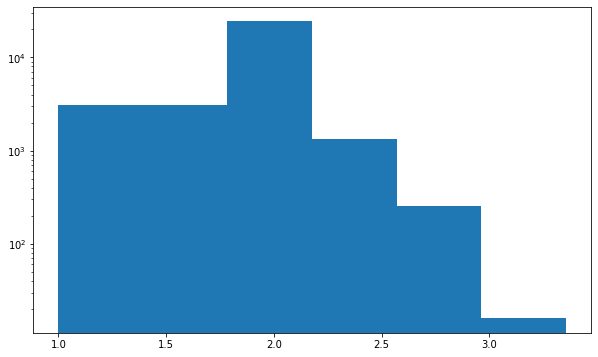

In [148]:
plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=6)
plt.yscale('log')
plt.show()

In [136]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=6,sort=False)


(0.997, 1.392]     3104
(1.392, 1.784]     3097
(1.784, 2.177]    24328
(2.177, 2.569]     1338
(2.569, 2.961]      252
(2.961, 3.353]       16
Name: Estimate_Score, dtype: int64

Parecido al modelo de benchmarking, este modelo optimizado concentra la mayoría de los datos cerca de la mitad del total de rankings (un comportamiento que se puede atribuir a que hablamos del mismo usuario). Pero al ser una calificación con más números es más fácil hacer la distinción de categorias y se reduce la cantidad de juegos recomendables a 16 (e incluso menos), que serían los juegos que tengan una puntuación de por lo menos 3 o cercanas a este valor. 

ahora bien, ¿cómo se comporta un usuario que solo tiene un producto?

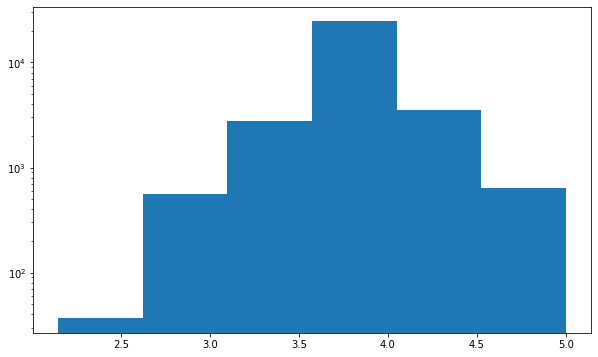

In [152]:
usuario2_5 = 'Kaelandros'
ranking2 = 5   # Juegos jugados por encima del tiempo promedio
df_user2 = reviws2[(reviws2['username'] == usuario2_5) & (reviws2['ranking'] >= ranking2)]
df_user2 = df_user2.reset_index(drop=True)
usuario_vistas = reviws2[reviws2['username'] == usuario2_5]
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True,errors='ignore')

recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: model.predict(usuario2_5, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)

plt.figure(figsize=(10,6))
plt.hist(recomendaciones_usuario.Estimate_Score,bins=6)
plt.yscale('log')
plt.show()

In [153]:
recomendaciones_usuario.Estimate_Score.value_counts(bins=6,sort=False)

(2.144, 2.624]       37
(2.624, 3.099]      561
(3.099, 3.574]     2773
(3.574, 4.049]    24568
(4.049, 4.525]     3555
(4.525, 5.0]        641
Name: Estimate_Score, dtype: int64

En este caso, el modelo si que encuentra juegos con calificaciones de 5. Claramente, el hecho de que el usuario solo tenga un juego abre las posibilidades a que le gusten muchisimo más y se demuestra con la acumulación de datos después de la nota 3.

Al igual que en el modelo de benchmark este modelo solo puede saber que le podría gustar al usuario al compararlo con usuarios que tienen el mismo producto, pero tiene dificultades en entender que NO le gusta, pues el usuario no tiene productos con calificaciones bajas. Por otro lado si resultó una mejora el cambiar la calificación a de 1 a 5, pues es mucho más fácil definir cuales sean los productos con mayor posibilidad de gustarle al usuario.

##Error del modelo

In [137]:
accuracy.rmse(predictions, verbose=True) #Corregir conclusiones

RMSE: 1.4332


1.4331983977276859

El error de este modelo puede considerarse bastante alto pues mayor a una unidad significa un cambio de nota en la recomendación. De todas formas, para usuarios con pocos productos y que reciban recomendaciones cercanas a 5, el error no debería importar mucho, pues el producto caería como menos en la categoría de "jugable por encima de la media" como minimo. 

##Conclusiones

Generar calificaciones usando las horas jugadas, aunque hace mucho sentido (al menos a mi aun) tiene el problema de no ser una calificación directa del usuario y, sobretodo, que nunca varios productos recibirán una calificación alta será dada a varios productos de un solo usuario.

El problema con este modelo es que: mientras en un modelo de notas normales un usuario puede tener casi todos sus productos calificados por encima de 4, en este modelo la "nota" se va a repartir entre todos los juegos (muy a pesar del gusto del usuario).

Este modelo puede resultar ventajoso porque nos podría estar indicando más que recomendaciones, tendencias entre usuarios con habitos de consumo parecido. Eso se traduce en que podría estar generando clusters y agrupanto estos en modas.

Una gran debilidad de este modelo, además de la información dada anteriormente, es que no considera el factor económico y poder adquisitivo del usuario; pero como se dijo, el ejercicio presentado en este notebook se relaciona más con generar la nota a partir de las horas de juego.

Finalmente, creo que la única forma de tener certeza en cuanto a la efectividad de este modelo sería contrastando los resultados de recomendación con entrevistas a los usuarios reales.

# Artículos de interes utilizados

https://medium.com/towards-artificial-intelligence/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444

https://www.kaggle.com/sunyuanxi/surprise